
# Readmission Prediction Project

## Objective:
This project aims to predict patient readmission within 30 days using hospital admission records, diagnoses, lab results, and patient demographics.

## Steps Performed:

1. **Data Loading**  
   - Imported multiple datasets, including admissions, diagnoses, lab events, and patient details.

2. **Data Preprocessing & Cleaning**  
   - Identified heart failure patients using ICD-9 codes.  
   - Merged datasets to create a comprehensive feature set.  
   - Processed lab events by computing the average value per patient.  
   - Dropped missing values and removed outliers using the IQR method.

3. **Feature Engineering**  
   - Derived the `readmitted` target variable based on discharge and admission times.  
   - Selected relevant features, including admission type, insurance, marital status, ethnicity, heart failure status, and lab values.  
   - Encoded categorical variables using `LabelEncoder`.

4. **Handling Class Imbalance**  
   - Applied **downsampling** to balance the dataset, ensuring equal representation of readmitted and non-readmitted patients.

5. **Model Training & Evaluation**  
   - Standardized numerical features using `StandardScaler`.  
   - Trained a **Random Forest Classifier** with optimized hyperparameters.  
   - Evaluated performance using accuracy, classification report, and confusion matrix.

6. **Feature Importance Analysis**  
   - Examined feature importance to understand which variables contribute most to readmission prediction.

7. **Manual Testing for New Patients**  
   - Implemented a function to test a new patient’s data and predict their likelihood of readmission.

## Observations:
- Certain features, like heart failure, had low importance, possibly due to correlation with other variables or data imbalances.
- The model’s performance can be further improved by feature selection and alternative machine learning algorithms.

# End 


### Importing essential libraries
### Loading Dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


# Ensure all necessary libraries are installed
try:
    import micropip
except ModuleNotFoundError:
    print("Warning: micropip module not found. Please check your environment setup.")

# Load datasets
print("Loading datasets...")
admissions = pd.read_csv("D:/readmission/admissions_202208161605.csv")
diagnoses = pd.read_csv("D:/readmission/diagnoses_icd_202208161605.csv")
drgs = pd.read_csv("D:/readmission/drgcodes_202208161605.csv")
cptevents = pd.read_csv("D:/readmission/cptevents_202208161605.csv")
labitems = pd.read_csv("D:/readmission/d_labitems_202208161605.csv")
labevents = pd.read_csv("D:/readmission/labevents_202208161605.csv")
patients = pd.read_csv("D:/readmission/patients_202208161605.csv")
procedures_icd = pd.read_csv("D:/readmission/procedures_icd_202208161605.csv")

Loading datasets...


C:\Users\DELL\AppData\Local\Temp\ipykernel_24204\3890968758.py:23: DtypeWarning: Columns (4,5,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  cptevents = pd.read_csv("D:/readmission/cptevents_202208161605.csv")


In [6]:
# Identifying Heart Failure Patients
print("Identifying heart failure patients based on diagnosis codes...")
heart_failure_codes = ['39891','40201','40211','40291','40401','40403','40411','40413','40491','40493',
                       '4280','4281','42820','42821','42822','42823','42830','42831','42832','42833',
                       '42840','42841','42842','42843','4289']
diagnoses['heart_failure'] = diagnoses['icd9_code'].astype(str).isin(heart_failure_codes).astype(int)

# Processing Lab Events Data
print("Processing lab events data...")
labevents['charttime'] = pd.to_datetime(labevents['charttime'], errors='coerce')
important_labs = labevents.groupby('hadm_id')['valuenum'].mean().reset_index()
important_labs.rename(columns={'valuenum': 'avg_lab_value'}, inplace=True)




Identifying heart failure patients based on diagnosis codes...
Processing lab events data...


### Merging different datasets
### Selecting Main features 

In [8]:

# Feature Engineering
print("Performing feature engineering...")
# Convert to datetime
# Convert to datetime in the admissions dataframe
# Merging Data
print("Merging datasets...")
df = admissions[['hadm_id', 'admittime', 'dischtime', 'admission_type', 'insurance', 'marital_status', 'ethnicity']] \
        .merge(diagnoses, on='hadm_id', how='left')

df = df.merge(important_labs, on='hadm_id', how='left')  # Adding lab results
df = df.merge(patients['subject_id'], on='subject_id', how='left')  # Adding patient data
df = df.merge(procedures_icd, on='hadm_id', how='left')  # Adding procedure data



print("Columns in df after merging:", df.columns)
print("Shape of df after feature selection and dropping NaNs:", df.shape)
print("First few rows of df:\n", df.head())

print("Sample data:\n", df.head())
print("Missing values per column:\n", df.isnull().sum())


# Convert to datetime
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])

# Compute readmission
df['readmitted'] = ((df['dischtime'] - df['admittime']).dt.days <= 30).astype(int)

# Check if dischtime and admittime exist in df
print(df.columns)  # Verify that 'dischtime' and 'admittime' are in the dataframe
print(df[['dischtime', 'admittime']].head())  # Check the first few rows

# Compute readmission after ensuring the columns exist
if 'dischtime' in df.columns and 'admittime' in df.columns:
    df['readmitted'] = ((df['dischtime'] - df['admittime']).dt.days <= 30).astype(int)
else:
    print("Error: 'dischtime' or 'admittime' is missing from df.")



df = df.drop(columns=['avg_lab_value'])
df['marital_status'] = df['marital_status'].fillna('UNKNOWN')


# Selecting Features for Prediction
features = ['admission_type', 'insurance', 'marital_status', 'ethnicity', 'heart_failure']
df = df[features + ['readmitted']]
print("Missing values per column before dropna:\n", df.isnull().sum())
df = df.dropna()
print("Shape after dropna:", df.shape)

df_sampled = df.sample(n=50000, random_state=42)  # Adjust the sample size as needed

print(df_sampled)








Performing feature engineering...
Merging datasets...
Columns in df after merging: Index(['hadm_id', 'admittime', 'dischtime', 'admission_type', 'insurance',
       'marital_status', 'ethnicity', 'row_id_x', 'subject_id_x', 'seq_num_x',
       'icd9_code_x', 'heart_failure', 'avg_lab_value', 'row_id_y',
       'subject_id_y', 'seq_num_y', 'icd9_code_y'],
      dtype='object')
Shape of df after feature selection and dropping NaNs: (3250116, 17)
First few rows of df:
    hadm_id                admittime                dischtime admission_type  \
0   165315  2196-04-09 12:26:00.000  2196-04-10 15:54:00.000      EMERGENCY   
1   165315  2196-04-09 12:26:00.000  2196-04-10 15:54:00.000      EMERGENCY   
2   165315  2196-04-09 12:26:00.000  2196-04-10 15:54:00.000      EMERGENCY   
3   165315  2196-04-09 12:26:00.000  2196-04-10 15:54:00.000      EMERGENCY   
4   165315  2196-04-09 12:26:00.000  2196-04-10 15:54:00.000      EMERGENCY   

  insurance marital_status ethnicity  row_id_x  subjec

### Encoding for Numerical purpose
### Splitting For training and test purpose 

In [10]:
# Encoding Categorical Variables
print("Encoding categorical features...")
label_encoders = {}
for col in ['admission_type', 'insurance', 'marital_status', 'ethnicity']:
    le = LabelEncoder()
    df_sampled[col] = le.fit_transform(df_sampled[col])
    label_encoders[col] = le

# Splitting Data into Training and Testing Sets
print("Splitting dataset into training and testing sets...")
X = df_sampled.drop(columns=['readmitted'])
y = df_sampled['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Encoding categorical features...
Splitting dataset into training and testing sets...


In [12]:
from sklearn.utils import resample

### Model Performance steps


Applying downsampling to balance the dataset...
Standardizing features...
Optimizing Random Forest Classifier using GridSearchCV...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Evaluating model performance...
Model Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.08      0.14      1686
           1       0.84      0.99      0.91      8314

    accuracy                           0.83     10000
   macro avg       0.71      0.53      0.52     10000
weighted avg       0.80      0.83      0.78     10000



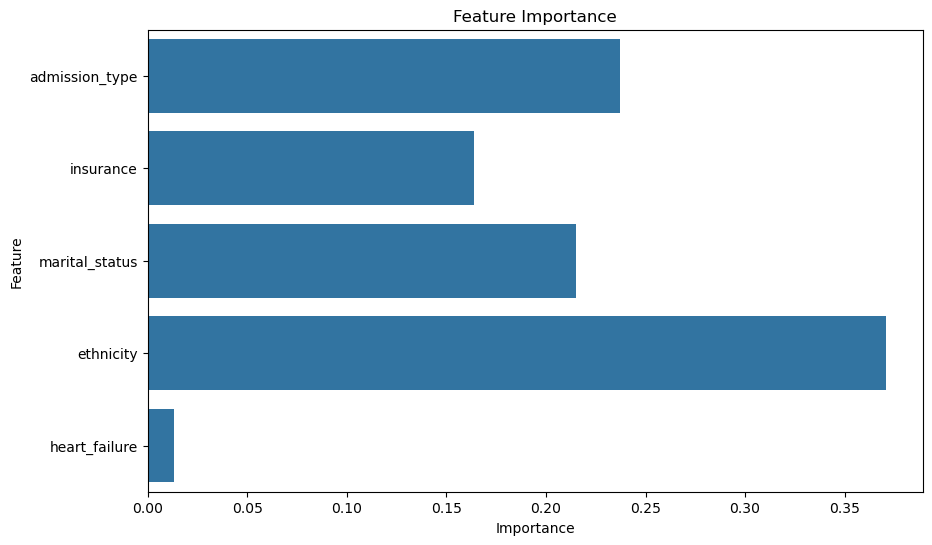

Generating confusion matrix heatmap...


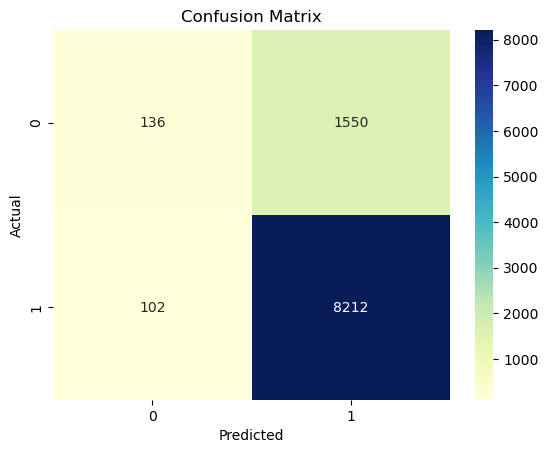

Process completed successfully!


In [22]:

# Handling Class Imbalance with Downsampling
print("Applying downsampling to balance the dataset...")
df_train = pd.concat([X_train, y_train], axis=1)
df_majority = df_train[df_train['readmitted'] == 0]
df_minority = df_train[df_train['readmitted'] == 1]
n_samples = min(len(df_majority), len(df_minority))
df_majority_downsampled = resample(df_majority, replace=False, n_samples=n_samples, random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])
X_train = df_balanced.drop(columns=['readmitted'])
y_train = df_balanced['readmitted']

# Standardizing Features
print("Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning using GridSearchCV
print("Optimizing Random Forest Classifier using GridSearchCV...")
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best Model Selection
rf_model = grid_search.best_estimator_

# Making Predictions
y_pred = rf_model.predict(X_test_scaled)

# Model Evaluation
print("Evaluating model performance...")
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualizing Feature Importance
feature_importances = rf_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Visualizing Results
print("Generating confusion matrix heatmap...")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Process completed successfully!")



### Manual Testing for a New Patient

In [17]:

print("Performing manual testing...")
def predict_new_patient(patient_data):
    patient_df = pd.DataFrame([patient_data])
    for col in ['admission_type', 'insurance', 'marital_status', 'ethnicity']:
        patient_df[col] = label_encoders[col].transform(patient_df[col])
    patient_scaled = scaler.transform(patient_df)
    prediction = rf_model.predict(patient_scaled)
    return "Readmitted" if prediction[0] == 1 else "Not Readmitted"

# Example patient data
new_patient = {
    'admission_type': 'EMERGENCY',
    'insurance': 'Medicare',
    'marital_status': 'MARRIED',
    'ethnicity': 'WHITE',
    'heart_failure': 1,
}

# Predicting readmission for the new patient
print("Predicted outcome for the new patient:", predict_new_patient(new_patient))

print("Process completed successfully!")


Performing manual testing...
Predicted outcome for the new patient: Readmitted
Process completed successfully!
